In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
df = pd.read_csv("./icmla+2014+accepted+papers+data+set/ICMLA_2014.csv", on_bad_lines='warn', encoding="ISO-8859-1")
df.head()

,paper_id,paper_title,author_keywords,abstract,session
0,1,Ensemble Statistical and Heuristic Models for ...,"statistical word alignment, ensemble learning,...",Statistical word alignment models need large a...,Ensemble Methods
1,2,Improving Spectral Learning by Using Multiple ...,"representation, spectral learning, discrete Fo...",Spectral learning algorithms learn an unknown ...,Ensemble Methods
2,3,Applying Swarm Ensemble Clustering Technique f...,"Software defect prediction, Particle swarm opt...",Number of defects remaining in a system provid...,Ensemble Methods
3,4,Reducing the Effects of Detrimental Instances,"filtering, label noise, instance weighting",Not all instances in a data set are equally be...,Ensemble Methods
4,5,Concept Drift Awareness in Twitter Streams,"Twitter, Adaptation models, Time-frequency ana...",Learning in non-stationary environments is not...,Ensemble Methods


We will only consider the abstract to cluster our data

In [3]:
text = df['abstract']
text.head()

0    Statistical word alignment models need large a...
1    Spectral learning algorithms learn an unknown ...
2    Number of defects remaining in a system provid...
3    Not all instances in a data set are equally be...
4    Learning in non-stationary environments is not...
Name: abstract, dtype: object

In [4]:
text.info()

<class 'pandas.core.series.Series'>
RangeIndex: 105 entries, 0 to 104
Series name: abstract
Non-Null Count  Dtype 
--------------  ----- 
105 non-null    object
dtypes: object(1)
memory usage: 968.0+ bytes


In [5]:
print(f"Minimum text length in text: {len(min(text))}\nMaximum text length in text: {len(max(text))}")

Minimum text length in text: 1167
Maximum text length in text: 1242


In [6]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
# Download the punkt tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
# Initialize the lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocess the text
def preprocess_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the text
text = text.apply(preprocess_text)

# Check the processed text
print(text.head())

0    statistical word alignment model need large am...
1    spectral learning algorithm learn unknown func...
2    number defect remaining system provides insigh...
3    instance data set equally beneficial inducing ...
4    learning environment easy task requires distin...
Name: abstract, dtype: object


In [8]:
print(f"Minimum text length in text: {len(min(text))}\nMaximum text length in text: {len(max(text))}")

Minimum text length in text: 943
Maximum text length in text: 878


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

text_vec = vectorizer.fit_transform(text)
# Check the shape of the TF-IDF matrix
print(f"TF-IDF matrix shape: {text_vec.shape}")

TF-IDF matrix shape: (105, 2299)


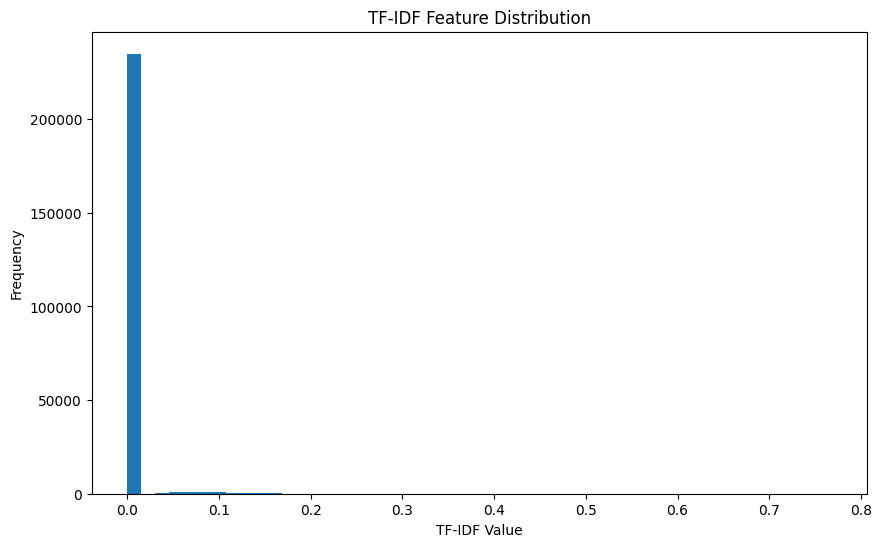

In [10]:
# Check feature distribution
plt.figure(figsize=(10,6))
plt.hist(text_vec.toarray().flatten(), bins=50)
plt.title('TF-IDF Feature Distribution')
plt.xlabel('TF-IDF Value')
plt.ylabel('Frequency')
plt.show()

In [11]:
text_vec.nnz

6507

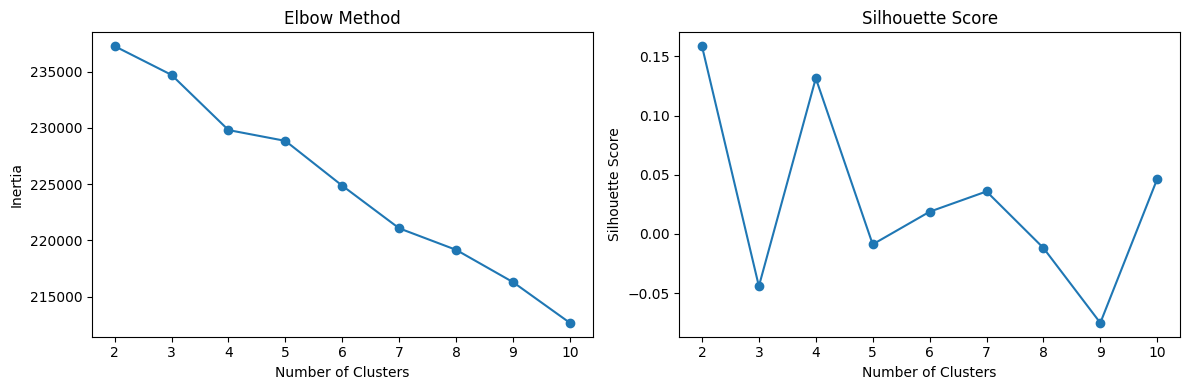

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Normalize the TF-IDF vectors
scaler = StandardScaler(with_mean=False)
text_vec_scaled = scaler.fit_transform(text_vec)

# Determine optimal number of clusters using elbow method and silhouette score
def find_optimal_clusters(data, max_clusters=10):
    # Elbow method
    inertias = []
    silhouette_scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Elbow method plot
    ax1.plot(range(2, max_clusters + 1), inertias, marker='o')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    
    # Silhouette score plot
    ax2.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score')
    
    plt.tight_layout()
    plt.show()
    
    return inertias, silhouette_scores

# Find optimal clusters
inertias, silhouette_scores = find_optimal_clusters(text_vec_scaled)

In [13]:
print(silhouette_scores)

[0.15872047597789218, -0.04428503907300579, 0.13160230087628297, -0.00887986454569815, 0.018723103708971633, 0.03588211125956581, -0.01191301147033994, -0.07526816172492921, 0.046468853085469546]


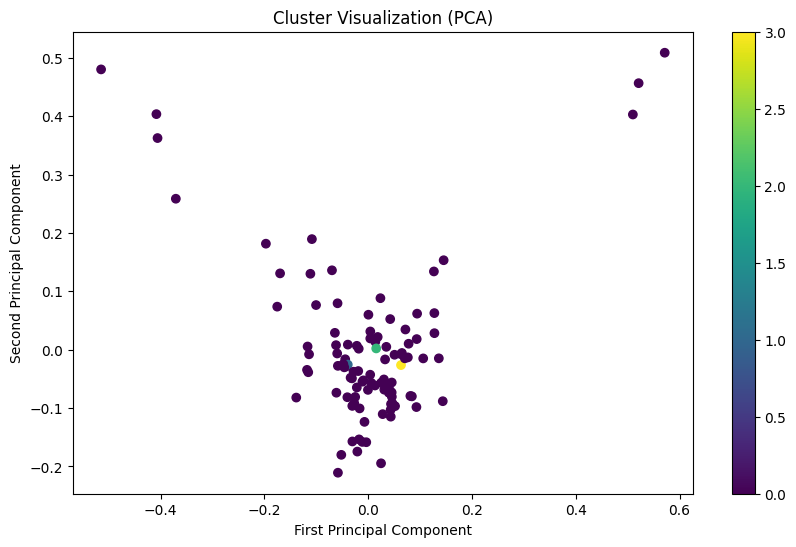

Cluster Sizes:
Cluster
0    102
3      1
2      1
1      1
Name: count, dtype: int64

Sample Papers per Cluster:

Cluster 0:
0    Ensemble Statistical and Heuristic Models for ...
1    Improving Spectral Learning by Using Multiple ...
2    Applying Swarm Ensemble Clustering Technique f...

Cluster 1:
82    TSD: Detecting Sybil Accounts in Twitter

Cluster 2:
62    Visualising Singing Style Under Common Musical...

Cluster 3:
21    A Cyclic Contrastive Divergence Learning Algor...


In [13]:
# let's choose 4 clusters
optimal_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(text_vec_scaled)

# Add cluster labels to the original dataframe
df['Cluster'] = cluster_labels

# Visualize clusters using PCA
def visualize_clusters(data, labels, n_components=2):
    # Reduce dimensionality for visualization
    pca = PCA(n_components=n_components)
    data_reduced = pca.fit_transform(data.toarray())
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(data_reduced[:, 0], data_reduced[:, 1], 
                          c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

# Visualize clusters
visualize_clusters(text_vec, cluster_labels)

# Analyze clusters
def analyze_clusters(df, cluster_column='Cluster'):
    # Group by cluster and get cluster sizes
    cluster_sizes = df[cluster_column].value_counts()
    print("Cluster Sizes:")
    print(cluster_sizes)
    
    # Sample papers from each cluster
    print("\nSample Papers per Cluster:")
    for cluster in range(optimal_clusters):
        print(f"\nCluster {cluster}:")
        sample_papers = df[df[cluster_column] == cluster]['paper_title'].head(3)
        print(sample_papers.to_string())

# Analyze clusters
analyze_clusters(df)

In [14]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

class Word2VecClustering:
    def __init__(self, df, text_column):
        self.df = df
        self.text_column = text_column
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
    
    def preprocess_text(self, text, do_lemmatization=True, remove_stopwords=True):
        # Tokenize
        tokens = word_tokenize(text.lower())
        
        # Remove stopwords
        if remove_stopwords:
            tokens = [token for token in tokens if token not in self.stop_words]
        
        # Lemmatization
        if do_lemmatization:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        # Keep only alphabetic tokens
        tokens = [token for token in tokens if token.isalpha()]
        
        return tokens
        
    def compare_preprocessing_approaches(self):
        # Different preprocessing configurations
        preprocessing_configs = [
            {"name": "No Preprocessing", 
             "do_lemmatization": False, 
             "remove_stopwords": False},
            {"name": "Remove Stopwords", 
             "do_lemmatization": False, 
             "remove_stopwords": True},
            {"name": "Lemmatization", 
             "do_lemmatization": True, 
             "remove_stopwords": False},
            {"name": "Full Preprocessing", 
             "do_lemmatization": True, 
             "remove_stopwords": True}
        ]
        
        results = {}
        best_silhouette_score = -1
        best_doc_vectors = None
        best_cluster_labels = None

        for config in preprocessing_configs:
            print(f"\n--- {config['name']} ---")
            
            # Preprocess texts
            processed_texts = self.df[self.text_column].apply(
                lambda x: self.preprocess_text(
                    x, 
                    do_lemmatization=config['do_lemmatization'], 
                    remove_stopwords=config['remove_stopwords']
                )
            )
            
            # Train Word2Vec
            model = Word2Vec(
                sentences=processed_texts, 
                vector_size=100,  # Embedding dimension
                window=5,         # Context window
                min_count=1,      # Minimum word frequency
                workers=8         # Parallel processing
            )
            
            # Create document vectors (mean of word vectors)
            doc_vectors = []
            for doc_tokens in processed_texts:
                if doc_tokens:
                    doc_vector = np.mean([model.wv[token] for token in doc_tokens], axis=0)
                    doc_vectors.append(doc_vector)
                else:
                    doc_vectors.append(np.zeros(100))  # Zero vector for empty docs
            
            doc_vectors = np.array(doc_vectors)
            
            # Clustering
            try:
                cluster_range = range(2, 20)
                silhouette_scores = []
                best_labels = None
                
                for n_clusters in cluster_range:
                    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                    cluster_labels = kmeans.fit_predict(doc_vectors)
                    
                    # Compute silhouette score
                    sil_score = silhouette_score(doc_vectors, cluster_labels)
                    silhouette_scores.append(sil_score)
                    
                    print(f"Clusters: {n_clusters}, Silhouette Score: {sil_score:.4f}")
                    
                    # Check for the best silhouette score
                    if sil_score > best_silhouette_score:
                        best_silhouette_score = sil_score
                        best_doc_vectors = doc_vectors
                        best_cluster_labels = cluster_labels
                
                # Store results
                results[config['name']] = {
                    'silhouette_scores': silhouette_scores,
                    'doc_vectors': doc_vectors
                }
                
                # Plot silhouette scores
                plt.plot(list(cluster_range), silhouette_scores, label=config['name'])
            
            except Exception as e:
                print(f"Error in clustering: {e}")
        
        # Finalize plot
        plt.title('Silhouette Scores for Different Preprocessing')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.legend()
        plt.xticks(cluster_range)
        plt.show()
        
        # Correctly indented return statement
        return best_doc_vectors, best_cluster_labels


--- No Preprocessing ---
Clusters: 2, Silhouette Score: 0.5141
Clusters: 3, Silhouette Score: 0.5293
Clusters: 4, Silhouette Score: 0.5326
Clusters: 5, Silhouette Score: 0.4971
Clusters: 6, Silhouette Score: 0.5205
Clusters: 7, Silhouette Score: 0.5371
Clusters: 8, Silhouette Score: 0.5445
Clusters: 9, Silhouette Score: 0.4773
Clusters: 10, Silhouette Score: 0.4584
Clusters: 11, Silhouette Score: 0.4656
Clusters: 12, Silhouette Score: 0.4711
Clusters: 13, Silhouette Score: 0.4746
Clusters: 14, Silhouette Score: 0.5027
Clusters: 15, Silhouette Score: 0.5062
Clusters: 16, Silhouette Score: 0.5007
Clusters: 17, Silhouette Score: 0.5026
Clusters: 18, Silhouette Score: 0.4953
Clusters: 19, Silhouette Score: 0.4794

--- Remove Stopwords ---
Clusters: 2, Silhouette Score: 0.0846
Clusters: 3, Silhouette Score: 0.0400
Clusters: 4, Silhouette Score: 0.0154
Clusters: 5, Silhouette Score: 0.0100
Clusters: 6, Silhouette Score: 0.0091
Clusters: 7, Silhouette Score: 0.0132
Clusters: 8, Silhouette Sc

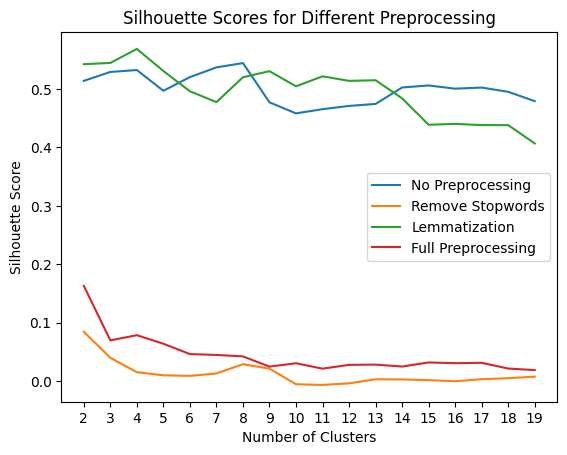

In [15]:
# Run the analysis
w2v_clustering = Word2VecClustering(df, 'abstract')
best_doc_vectors, best_cluster_labels = w2v_clustering.compare_preprocessing_approaches()

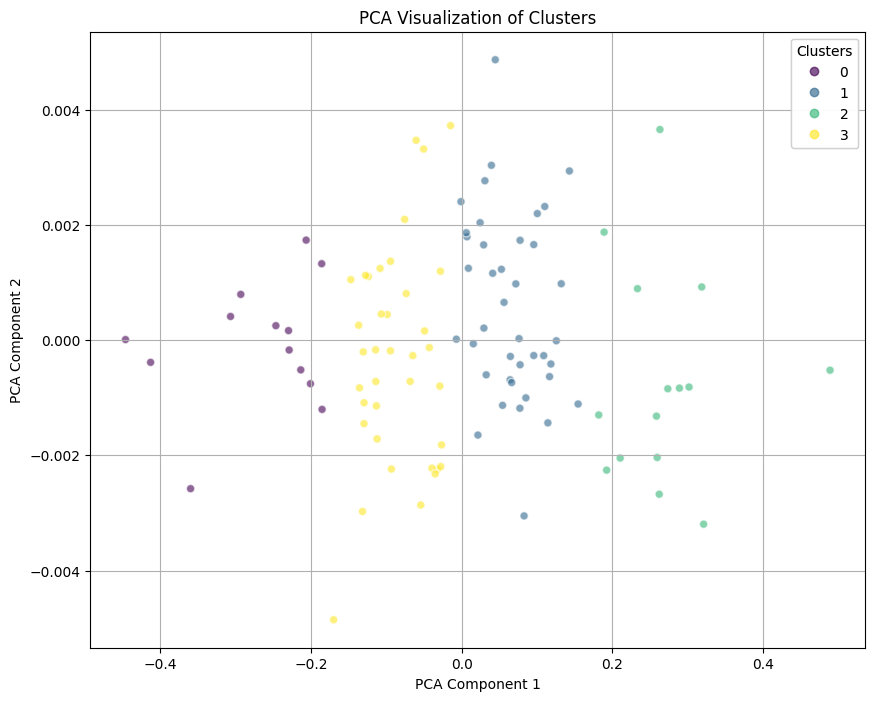

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_clusters_pca(doc_vectors, cluster_labels):
    # Reduce dimensions using PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_vectors = pca.fit_transform(doc_vectors)

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], 
                          c=cluster_labels, cmap='viridis', alpha=0.6, edgecolors='w')

    # Create a legend
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)

    plt.title('PCA Visualization of Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.show()

# Example usage
# Assuming you have `best_doc_vectors` and `best_cluster_labels` from your KMeans clustering
visualize_clusters_pca(best_doc_vectors, best_cluster_labels)

In [17]:
best_doc_vectors

array([[-0.18467566,  0.16129248,  0.04718722, ..., -0.20261443,
         0.08830941, -0.03578644],
       [-0.19456895,  0.17037435,  0.04986601, ..., -0.21187524,
         0.09291971, -0.03847387],
       [-0.19071554,  0.16776411,  0.04773068, ..., -0.2106777 ,
         0.09101125, -0.03806281],
       ...,
       [-0.1693119 ,  0.1482406 ,  0.04258153, ..., -0.1864059 ,
         0.08208469, -0.03335917],
       [-0.19705223,  0.17326805,  0.05040967, ..., -0.21832158,
         0.09453241, -0.03888826],
       [-0.18399175,  0.16064873,  0.04688631, ..., -0.20053066,
         0.08655233, -0.03626027]], dtype=float32)

In [18]:
best_cluster_labels

array([3, 1, 3, 1, 1, 1, 0, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 0, 1, 3,
       1, 1, 3, 1, 3, 1, 3, 1, 2, 1, 2, 2, 1, 3, 1, 1, 3, 3, 0, 3, 1, 3,
       2, 2, 0, 3, 3, 0, 2, 2, 2, 3, 3, 3, 2, 1, 2, 2, 2, 3, 3, 1, 3, 1,
       1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 3, 3, 1, 3, 2, 0, 0, 3, 1, 2, 1,
       0, 2, 1, 1, 3, 3, 1, 0, 1, 1, 0, 1, 0, 3, 0, 1, 3])

In [19]:
from collections import Counter

label_counts = Counter(best_cluster_labels)

for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: 3, Count: 37
Label: 1, Count: 40
Label: 0, Count: 13
Label: 2, Count: 15


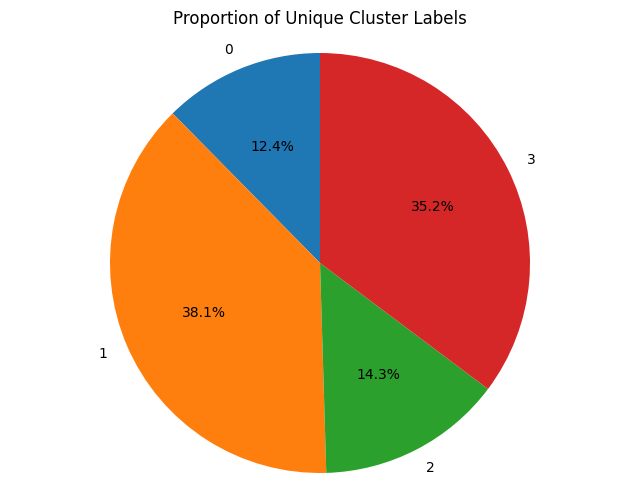

In [20]:
# Count unique values
unique_labels, counts = np.unique(best_cluster_labels, return_counts=True)

# Create a DataFrame
df_counts = pd.DataFrame({'Label': unique_labels, 'Count': counts})

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(df_counts['Count'], labels=df_counts['Label'], autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Unique Cluster Labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()